 ## Q7 Most popular tweets:

    - Most popular tweets means here is the tweet which has been re-tweeted maximum number of times.
    - Get top 100 most re-tweeted tweets in last 1 hour related to “iphone”.



In [1]:
from __future__ import print_function

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn # For plotting
import time
import json

from IPython import display  # To work with graphs on jupyter
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc
from collections import namedtuple #function for creating tuple subclasses with named fields

In [2]:
# magic function to plot inline
%matplotlib inline

In [3]:
if __name__ == "__main__":

    sc = SparkContext(appName="TwitterRetweet")
    ssc = StreamingContext(sc, 60 * 60)  # Setting 1hr interval
    sqlContext = SQLContext(sc)  # Sql context for running sql query
 
    # Host port of server which is sending text stream
    host = "localhost"
    port = 8700
    socketStream = ssc.socketTextStream(host, port) # Connecting to socket
    dStream = socketStream.window(60 * 60)  # Setting 1hr window
    
    def parseTweet(dStream): # Data Manupulation
        try:
            data = json.loads(dStream)  # Load the json data
            return [( # Tuple of name and follower count
                     data.get("text", "undefined"), 
                     int(data.get("retweetcount", 0))
                    )]
        except:
            return []
        
    def displayTweet(time, rdd): # Print the data in readable format
        try:
            print(time)
            print("Top 100 Popular Tweets: ")
            print("Rank".center(6, "-") + "|" + "Tweet".center(40, "-") + "|" + "Retweet Count".center(20, "-"))
            for rank, item in enumerate(rdd.distinct().takeOrdered(100, key=lambda x: -x[1])):
                print(str(rank + 1).center(6, " ") + 
                      "|" + item[0] + 
                      "|" + str(item[1]).rjust(15, " ")
                     )
        except ValueError:
            pass
    
    _influencial = dStream.flatMap(parseTweet)\
                          .transform(  # Sorting the data
                                     lambda rdd: rdd.sortBy(lambda x: x[1], ascending=False)
                          ).foreachRDD(displayTweet)
    
    fields = ("id", "count")
    Tweet = namedtuple('Tweet', fields)
    # DStream where all the computation is done
    (dStream.flatMap(parseTweet)\
                          .transform(  # Sorting the data
                                     lambda rdd: rdd.sortBy(lambda x: x[1], ascending=False)
                          )\
          .map(lambda rec: Tweet(rec[0], rec[1]))\
          .foreachRDD(lambda rdd: rdd.toDF().sort(desc("count"))\
                      .limit(10).registerTempTable("tweets")))
        
    ssc.start()
#    ssc.awaitTermination()

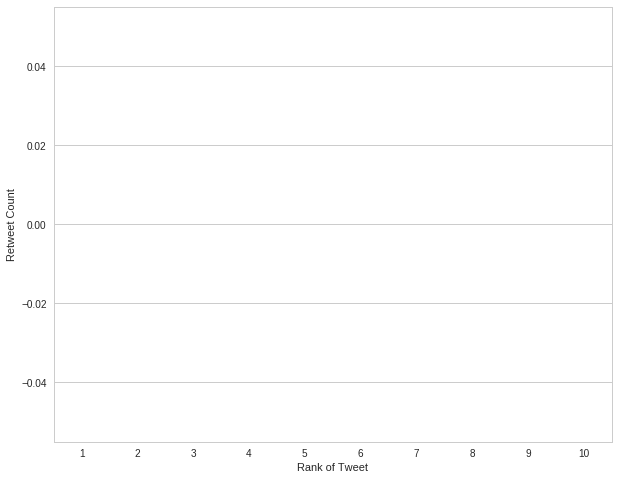

2017-10-08 19:39:50
Top 100 Popular Tweets: 
-Rank-|-----------------Tweet------------------|---Retweet Count----
  1   |Learn something new every day: "How to Use Your iPhone as an Audio Input on Your Mac" https://t.co/vCD1e2BGks|              0
  2   |モイ！iPhoneからキャス配信中 - / ザッツダーン！！！ https://t.co/M0YGeQUlLN|              0
  3   |RT @DtimesDream: 【 #Dtimes読者プレゼント 】
フォロー&amp;RTで #イングレム ディズニーデザイン｢スマホ耐衝撃ケース キャトル｣（iPhone 8/7/6s/6用） ミニーデザインを1名様にプレゼント☆
〆切は10月15日まで！
商品詳細… |              0
  4   |RT @busou_shoutotsu: 【#ドイ帰れま10 完遂！】
このツイキャスを見ていただけたらわかる通りミッション4&amp;5同時クリア！
これにてドイの帰れま10無事に終了！
武装衝突の三連休ジャック大トリは明日！えのの帰ります！朝10時スタート！
乞うご期待！… |              0
  5   |モイ！iPhoneからキャス配信中 - https://t.co/SpXd4NhuzU|              0
  6   |Harry Potter Quotes Cover Case for iPhone https://t.co/2P8OhV6chf ... https://t.co/wzdZp6VVyE https://t.co/xs8YR4nkAi|              0
  7   |iPhoneの画像フォルダみると、思い出が染みてくる。変な言い方だけど、俺結構付き合って遊べてやれたら充分とか思うタイプのとこもあるから絶対に珍しい( ･᷄･᷅ )|              0
  8   |RT @martyswant: Asked by Da

In [4]:
while True:  # Display graph here
    try:
        time.sleep(60 * 60)  # Sleep 1hr, plot graph every hour
        topics = sqlContext.sql('Select id, count from tweets')
        topics = topics.toPandas()
        display.clear_output(wait=True)
        sn.set_style("whitegrid")  # Styling of plot
        sn.plt.figure(figsize = (10, 8)) # Figuresize of plot
        ax = sn.barplot(x=(topics.index.values + 1), y=topics["count"], estimator=sum)
        ax.set(xlabel='Rank of Tweet', ylabel='Retweet Count') # Labeling of plot
        sn.plt.show()
    except KeyboardInterrupt:  # User interrupt
        ssc.stop()
        print("Stoping the program")
        break
    # Continue even if there is exception and stop only on Keyboard Interrupt
    except Exception as e:  
        print(e)
        continue

# Insights

The reason why retweet count is always 0 is because we receive the tweets as they are posted live on twitter platform, by the time we receive the tweet no other user had a chance to retweet it. If we want to find out the retweet_count we have to refetch this particular tweet some time later using the rest api then we can see the retweet_count will contain the number of retweets happened till this particular point in time. This is not done here currently, because hitting rest api for such a large amount of tweets will hit the limit.